In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.api import SimpleExpSmoothing
from sklearn.cluster import DBSCAN
from sklearn.metrics import mean_squared_error
import os

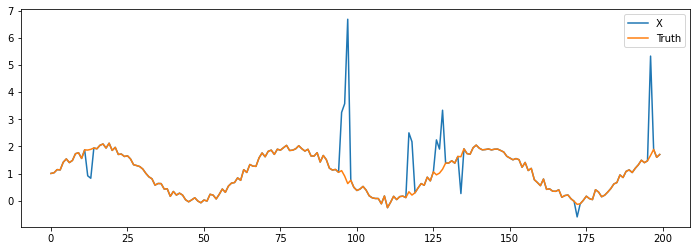

In [2]:
sample = pd.read_csv('../data/sample3.csv')
plt.figure(figsize=(12, 4))
sample[:200].plot(ax=plt.gca())
plt.show()

In [3]:
alpha = 0.3
n = sample.X.shape[0] - 1
fit = SimpleExpSmoothing(sample.X).fit(alpha)
X_clean = fit.predict(0, n)
fit = SimpleExpSmoothing(X_clean[::-1]).fit(alpha)
X_clean = fit.predict(0, n)[::-1]

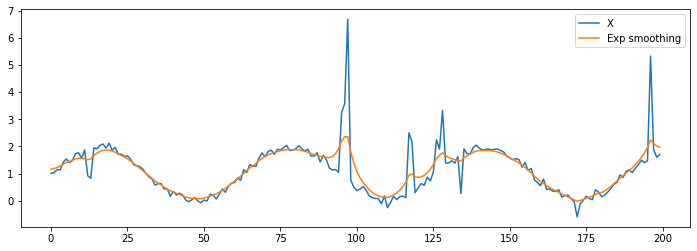

In [4]:
plt.figure(figsize=(12, 4))
sample[:200].X.plot(label='X')
X_clean[:200].plot(label='Exp smoothing')
plt.legend()
plt.show()

Difference

In [5]:
X_diff = sample.X - X_clean

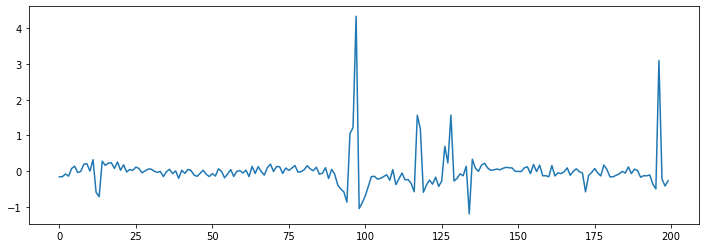

In [6]:
plt.figure(figsize=(12, 4))
X_diff[:200].plot()
plt.show()

# DBSCAN

In [7]:
def dbscan_diff(X):
    
    n = 1000 # number of observations for fitting
    X_clean = X.copy()
    
    for i in range(3):
    
        # calculate diff
        alpha = 0.5
        fit = SimpleExpSmoothing(X_clean).fit(alpha)
        X_smooth = fit.predict(0, X_clean.shape[0] - 1)
        fit = SimpleExpSmoothing(X_smooth[::-1]).fit(alpha)
        X_smooth = fit.predict(0, X_clean.shape[0] - 1)[::-1]
        
        X_diff = X - X_smooth
        X_diff = X_diff / np.linalg.norm(X_diff)
        X_diff = np.reshape(X_diff, (X_diff.shape[0], 1))

        # fit eps
        eps_space = np.linspace(0.00001, 0.00025, 100)
        cluster_size = []
        for eps in eps_space:
            dbscan = DBSCAN(eps=eps).fit(X_diff[:n])
            largest_size = 0
            for label in set(dbscan.labels_):
                len_set = (dbscan.labels_ == label).sum()
                if largest_size < len_set:
                    largest_size = len_set
            cluster_size.append(largest_size / n * 100)
        cluster_size = np.array(cluster_size)
        best_eps = eps_space[np.argmax(cluster_size[1:] - cluster_size[:-1]) + 1]

        # clustering
        dbscan = DBSCAN(eps=best_eps).fit(X_diff)

        # updating
        largest_size = 0
        largest_cluster = None
        for label in set(dbscan.labels_):
            len_set = (dbscan.labels_ == label).sum()
            if largest_size < len_set:
                largest_size = len_set
                largest_cluster = label

        X_clean[dbscan.labels_ != largest_cluster] = None
        X_clean = pd.Series(X_clean).interpolate().values
        X_clean[np.argwhere(np.isnan(X_clean))] = X_smooth[np.argwhere(np.isnan(X_clean))]
    
    return X_clean

In [8]:
def get_files_list(path):
    files = []
    for aname in os.listdir(path):
        if (aname[-3:] == "csv") or (aname[-3:] == "txt"): 
            files.append(os.path.join(path, aname))
    return files

def run_tests(dir_path):
    
    print("Dataset: ", dir_path)
    files = get_files_list(dir_path)
    files.sort()
    
    report = pd.DataFrame(columns=["Sample", "RMSE"])
    
    for afile in files:
        
        print("File: ", afile)
            
        data = pd.read_csv(afile, index_col=False)
        
        X      = data['X'].values
        X_true = data['Truth'].values
        
        X_clean = dbscan_diff(X)
        
        rmse = mean_squared_error(X_true, X_clean, squared=False)
        
        report.loc[len(report)] = [afile, rmse]
        print("RMSE: ", rmse)
            
    return report

In [9]:
dbscan_report = run_tests('../data/')
dbscan_report

Dataset:  ../data/
File:  ../data/sample1.csv
RMSE:  0.1280157447128531
File:  ../data/sample2.csv
RMSE:  0.10346389610467366
File:  ../data/sample3.csv
RMSE:  0.11401401173557847
File:  ../data/sample4.csv
RMSE:  0.1383702081165214
File:  ../data/sample5.csv
RMSE:  0.11449500018065263
File:  ../data/sample6.csv
RMSE:  2.172553637567568
File:  ../data/sample7.csv
RMSE:  6.152820217963181
File:  ../data/sample8.csv
RMSE:  0.561534197668392
File:  ../data/sample9.csv
RMSE:  84.61115874885627


Sample       RMSE
0  ../data/sample1.csv   0.128016
1  ../data/sample2.csv   0.103464
2  ../data/sample3.csv   0.114014
3  ../data/sample4.csv   0.138370
4  ../data/sample5.csv   0.114495
5  ../data/sample6.csv   2.172554
6  ../data/sample7.csv   6.152820
7  ../data/sample8.csv   0.561534
8  ../data/sample9.csv  84.611159

# Confidence interval

In [10]:
def conf_int(X):
    X_clean = X.copy()
    for i in range(4):
        
        # calculate diff
        alpha = 0.5
        fit = SimpleExpSmoothing(X_clean).fit(alpha)
        X_smooth = fit.predict(0, X_clean.shape[0] - 1)
        fit = SimpleExpSmoothing(X_smooth[::-1]).fit(alpha)
        X_smooth = fit.predict(0, X_clean.shape[0] - 1)[::-1]
        
        X_diff = X - X_smooth
        X_diff = X_diff / np.linalg.norm(X_diff)
        
        sigma_space = np.linspace(0, X_diff.max(), 100)
        av_diff = X_diff.mean()
        size_space = np.array(
            [((X_diff <= av_diff - sigma) | (av_diff + sigma <= X_diff)).sum() for sigma in sigma_space]
        )
        diff = size_space[1:] - size_space[:-1]
        best_sigma = sigma_space[np.argwhere(diff > -0.007 * X_diff.shape[0])[0][0]]

        X_clean[np.argwhere((X_diff <= av_diff - best_sigma) | (av_diff + best_sigma <= X_diff))] = None
        X_clean = pd.Series(X_clean).interpolate().values
        X_clean[np.argwhere(np.isnan(X_clean))] = X_smooth[np.argwhere(np.isnan(X_clean))]
        
    return X_clean

In [11]:
def get_files_list(path):
    files = []
    for aname in os.listdir(path):
        if (aname[-3:] == "csv") or (aname[-3:] == "txt"): 
            files.append(os.path.join(path, aname))
    return files

def run_tests(dir_path):
    
    print("Dataset: ", dir_path)
    files = get_files_list(dir_path)
    files.sort()
    
    report = pd.DataFrame(columns=["Sample", "RMSE"])
    
    for afile in files:
        
        print("File: ", afile)
            
        data = pd.read_csv(afile, index_col=False)
        
        X      = data['X'].values
        X_true = data['Truth'].values
        
        X_clean = conf_int(X)
        
        rmse = mean_squared_error(X_true, X_clean, squared=False)
        
        report.loc[len(report)] = [afile, rmse]
        print("RMSE: ", rmse)
            
    return report

In [12]:
conf_int_report = run_tests('../data/')
conf_int_report

Dataset:  ../data/
File:  ../data/sample1.csv
RMSE:  0.12177028801561215
File:  ../data/sample2.csv
RMSE:  0.08299601267626178
File:  ../data/sample3.csv
RMSE:  0.08428501477129755
File:  ../data/sample4.csv
RMSE:  0.11099288474336184
File:  ../data/sample5.csv
RMSE:  0.09770987802184088
File:  ../data/sample6.csv
RMSE:  1.2989265632339466
File:  ../data/sample7.csv
RMSE:  6.275960243512485
File:  ../data/sample8.csv
RMSE:  0.5498418412305939
File:  ../data/sample9.csv
RMSE:  88.0101606354256


Sample       RMSE
0  ../data/sample1.csv   0.121770
1  ../data/sample2.csv   0.082996
2  ../data/sample3.csv   0.084285
3  ../data/sample4.csv   0.110993
4  ../data/sample5.csv   0.097710
5  ../data/sample6.csv   1.298927
6  ../data/sample7.csv   6.275960
7  ../data/sample8.csv   0.549842
8  ../data/sample9.csv  88.010161

In [13]:
board = pd.DataFrame(columns=['Data preparation', 'Model']+['sample'+str(i) for i in range(1, 10)])
board.loc[len(board)] = ['Exponention smoothing', 'DBSCAN'] + list(dbscan_report['RMSE'].values)
board.loc[len(board)] = ['Exponention smoothing', 'Threshold'] + list(conf_int_report['RMSE'].values)
board = board.set_index(['Data preparation', 'Model'])
board

sample1   sample2   sample3   sample4  \
Data preparation      Model                                               
Exponention smoothing DBSCAN     0.128016  0.103464  0.114014  0.138370   
                      Threshold  0.121770  0.082996  0.084285  0.110993   

                                  sample5   sample6  sample7   sample8  \
Data preparation      Model                                              
Exponention smoothing DBSCAN     0.114495  2.172554  6.15282  0.561534   
                      Threshold  0.097710  1.298927  6.27596  0.549842   

                                   sample9  
Data preparation      Model                 
Exponention smoothing DBSCAN     84.611159  
                      Threshold  88.010161

In [14]:
board.iloc[[0], :].to_csv('../results/exp_smooth_dbscan.csv')
board.iloc[[1], :].to_csv('../results/exp_smooth_conf_int.csv')